<a href="https://colab.research.google.com/github/ME-UoP-ME421/Rankine-WS/blob/main/E17401_(task3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INSTRUCTIONS

* This is a group assignment. Complete the activities in groups that were assigned for ME421 for the vibrations lab.

* Make a copy of this and save it in your group github group repository.

* Do all your work, EXCLUSIVELY, in that saved notebook. Your github commits will serve as a refelection of your individual contributions. It will constitute 25% of your final grade for the lab.

* Complete Tasks#1 and Task#2 by 5:00PM on 14/06/2023

* Complete Tasks#3 and the Task#4 by 5:00PM on 21/06/2023 and demonstrate the work in the class on 21/06/2023.

* Complete Task#5 by 5:00PM on 28/06/2023.

#References

* https://colab.research.google.com/github/mugalan/classical-mechanics-from-a-geometric-point-of-view/blob/main/rigid-body-control/Mugas_Rigid_Body_Control.ipynb

* https://github.com/mugalan/classical-mechanics-from-a-geometric-point-of-view/blob/main/rigid-body-control/MaithriPalaDHS_RigidBodyPIDControl_IITB_18_03_2023.pdf

In [59]:
import math
import numpy as np
from numpy import linalg
from scipy.integrate import odeint
import plotly.graph_objects as go

from sympy import symbols
from sympy import *

from sympy.physics.mechanics import dynamicsymbols, init_vprinting

In [60]:
class mugas_rigid_body_functions:

  def __init__(self):
    self=[];

  def simulateDySystem(self, dynamicSystemModel, Tmax, dT, X0, sysPara, figTitle, xLabel, yLabel):
    t = np.linspace(0, Tmax, int(Tmax/dT+1))
    sol = odeint(dynamicSystemModel, X0, t, args=(sysPara,));
    self.soln=sol;
    fig = go.Figure()
    [nt,nS]=sol.shape;

    # Add traces
    for nn in range(nS):
      fig.add_trace(go.Scatter(x=t, y=sol[:,nn], mode='lines+markers', name='x'+str(nn+1)))
      fig.update_layout(title=figTitle, xaxis=dict(title=xLabel),yaxis=dict(title=yLabel))

    fig.show()
    return [t,sol,fig]

  def hatMatrix(self, X):
    return np.array([[0., -X[2], X[1]],[X[2], 0., -X[0]],[-X[1], X[0], 0.]])

  def qFromAxisAngles(self, theta, unitAxis):
    return np.concatenate(([np.cos(theta/2)],np.sin(theta/2)*np.array(unitAxis)))

  def RfromQuaternions(self,q):
    q0=q[0]; w=q[1:];
    R=np.identity(3)+2*q0*self.hatMatrix(w)+2*self.hatMatrix(w) @ self.hatMatrix(w);
    return R

  def rotationMatrix2EulerAngles(self,R):
    if R[2,2] <1:
      if R[2,2] > -1:
        theta2=math.acos(R[2,2]);
        theta1=math.atan2(R[0,2],R[1,2]);
        theta3=math.atan2(R[2,0],-R[2,1]);
      else: #R[2,2]=-1 No Unique solution
        theta2=np.pi;
        theta1=-math.atan2(R[0,1],-R[0,0]);
        theta3=0;
    else: # R[2,2] = +1 No Unique solution
      theta2 = 0;
      theta1 = math.atan2(R[0,1],R[0,0]) ;
      theta3 = 0;
    return [np.pi-theta1,theta2,np.pi-theta3]

  def Re3equalsgamma(self,gamma):
    theta=math.acos(gamma[2]);
    n1=-gamma[1]/np.sin(theta);
    n2=gamma[0]/np.sin(theta);
    q00=self.qFromAxisAngles(theta,[n1,n2,0]);

    return self.RfromQuaternions(q00)

  def rotate_and_translate(self,objectVertices,R,b):
    #object vertices should be given as an numpy array of shape (3,n)
    #Ex - X=[0, 0, 2, 2, 0, 0, 2, 2], Y=[0, 2, 2, 0, 0, 2, 2, 0], Z=[0, 0, 0, 0, 1, 1, 1, 1]; objectVertices=[X,Y,Z]
    return np.array([[b[0],b[1],b[2]]]).T + R @ objectVertices



  def addOrthNormFrame(self, fig, o, R, axisRange, axisColor):
    e1=[1,0,0]; e2=[0,1,0]; e3=[0,0,1];
    b1=R @ e1; b2=R @ e2; b3=R @ e3;
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b1[0])], y=[str(o[1]),str(o[1]+b1[1])], z=[str(o[2]),str(o[2]+b1[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b2[0])], y=[str(o[1]),str(o[1]+b2[1])], z=[str(o[2]),str(o[2]+b2[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b3[0])], y=[str(o[1]),str(o[1]+b3[1])], z=[str(o[2]),str(o[2]+b3[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.update_layout(showlegend=False, scene=dict(xaxis=dict(range=axisRange[0], autorange=False), yaxis=dict(range=axisRange[1], autorange=False), zaxis=dict(range=axisRange[2], autorange=False), aspectratio=dict(x=1, y=1, z=1)))
    return fig

  def cube_vertices(self,cubeDimensions):
    l=cubeDimensions['l']; w=cubeDimensions['w']; h=cubeDimensions['h'];
    xp=cubeDimensions['xp']; yp=cubeDimensions['yp']; zp=cubeDimensions['zp'];
    #X=[0, 0, l, l, 0, 0, l, l]; Y=[0, w, w, 0, 0, w, w, 0]; Z=[0, 0, 0, 0, h, h, h, h]; XX=[X,Y,Z];
    X=[-xp, -xp, l-xp, l-xp, -xp, -xp, l-xp, l-xp]; Y=[-yp, w-yp, w-yp, -yp, -yp, w-yp, w-yp, -yp]; Z=[-zp, -zp, -zp, -zp, h-zp, h-zp, h-zp, h-zp]; XX=[X,Y,Z];
    #X=[-l, -l, l, l, -l, -l, l, l]; Y=[-w, w, w, -w, -w, w, w, -w]; Z=[-h, -h, -h, -h, h, h, h, h]; XX=[X,Y,Z];
    return XX


  def animate_particle_motion(self, XX, axisRange, figTitle):
    xx=[jj[0] for jj in XX]
    yy=[jj[1] for jj in XX]
    zz=[jj[2] for jj in XX]

    fig = go.Figure(
        data=[go.Scatter3d(x=[xx[0]], y=[yy[0]],z=[zz[0]],
                        mode="markers",
                        marker=dict(color="red", size=10)),
              go.Scatter3d(x=xx, y=yy,z=zz, name='Path',
                        mode="lines",
                        line=dict(color="blue", width=2))],
        layout=go.Layout(
            scene = dict(
                        xaxis=dict(range=axisRange[0], autorange=False),
                        yaxis=dict(range=axisRange[1], autorange=False),
                        zaxis=dict(range=axisRange[2], autorange=False),
                        aspectratio=dict(x=1, y=1, z=1),
            ),
            title_text=figTitle, hovermode="closest",
            updatemenus=[dict(type="buttons",
                              buttons=[dict(label="Play",
                                            method="animate",
                                            args=[None])])]),
        frames=[go.Frame(
            data=[go.Scatter3d(
                x=[p[0]],
                y=[p[1]],
                z=[p[2]],
                name='Particle',
                mode="markers",
                marker=dict(color="red", size=10))])

            for p in XX]
    )

    fig.show()
    return fig

  def animated_cube_flat_shading(self, cubeVertices,figTitle):
    fig = go.Figure(
        frames=[go.Frame(data=[
          go.Mesh3d(
            # 8 vertices of a cube
            x=xx[0][0],
            y=xx[0][1],
            z=xx[0][2],
            # i, j and k give the vertices of triangles
            i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
            j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            name='y',
            opacity=0.6,
            color='#DC143C',
            flatshading = True)]) for xx in cubeVertices])

    fig.add_trace(go.Mesh3d(
            # 8 vertices of a cube
            x=cubeVertices[0][0][0],
            y=cubeVertices[0][0][1],
            z=cubeVertices[0][0][2],
            # i, j and k give the vertices of triangles
            i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
            j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            name='y',
            opacity=0.6,
            color='#DC143C',
            flatshading = True)
        )
    duration=10;
    fig.update_layout(
          title=figTitle,
          width=1200,
          height=1200,
          scene=dict(
                      xaxis=dict(range=[-5., 10.], autorange=False),
                      yaxis=dict(range=[-5., 10.], autorange=False),
                      zaxis=dict(range=[-5., 10.], autorange=False),
                      aspectratio=dict(x=1, y=1, z=1),
                      ),
          updatemenus=[
    dict(
        type="buttons",
        buttons=[
            dict(
                label="Play",
                method="animate",
                args=[
                    None,
                    {
                        "frame": {"duration": duration},
                        "mode": "immediate",
                        "fromcurrent": True,
                        "transition": {"duration": duration, "easing": "linear"},
                    }
                ]
            ),
            dict(
                label="Pause",
                method="animate",
                args=[
                    None,
                    {
                        "frame": {"duration": 0},
                        "mode": "immediate",
                        "fromcurrent": True,
                        "transition": {"duration": 0},
                    }
                ]
            )
        ]
    )
])
    len(fig.frames)
    fig.show()
    return fig

  def simulating_a_cube(self, dt, Tmax, cubeDimensions, parameters,ICs):
    XX=self.cube_vertices(cubeDimensions);

    #Xs=self.eulers_method(dt,Tmax,parameters,ICs);
    Xs=self.runga_kutta_method(dt,Tmax,parameters,ICs);
    ICR=ICs[0][0];
    XX0=ICR @ XX;

    rotatedVertices=[[XX0]]
    for X in Xs:
      #print(X[0])
      R=X[0][0];
      o=X[0][1];
      XXi=self.rotate_and_translate(XX,R,o);
      XX0=XXi;
      rotatedVertices+=[[XX0]];
    return rotatedVertices


  def eulers_method(self, dt,Tmax,parameters,ICs):
    M=parameters['M']; II=parameters['II'];
    invII=linalg.inv(II) ;
    timeSteps=np.arange(0,Tmax+dt,dt);
    R=ICs[0][0]; o=ICs[0][1];
    omega=ICs[1]; doto=ICs[2]; Xc=ICs[3];
    X=ICs;
    spi=R@II@R.T@omega; p=M*doto;
    Xout=[X];
    for t in timeSteps:
      [taue,fe]=externalForceModel(self, parameters,X);
      [taua,fa]=actuator(self, parameters, t, X,taue,fe);

      dspi=taue+taua;
      dp=fe+fa;
      #dXc=controller_dynamics(self, t,X,taue,fe,parameters)

      if linalg.norm(omega)>=0.0001:
        nomega=omega/linalg.norm(omega);
        thetaomegat=dt*linalg.norm(omega);
      else:
        nomega=np.array([0,0,0]);
        thetaomegat=0;
      qomegat=np.concatenate(([np.cos(thetaomegat/2)],np.sin(thetaomegat/2)*nomega));
      R=self.RfromQuaternions(qomegat) @ R;
      o=o+dt*doto;
      spi=spi+dt*dspi;
      p=p+dt*dp;
      doto=p/M;
      omega=R @ invII @ R.T @ spi;
      Xc=Xc#+dt*dXc;
      X=[[R,o],omega,doto, Xc];
      Xout+=[X]

    return Xout

  def runga_kutta_method(self, dt,Tmax,parameters,ICs):
    M=parameters['M']; II=parameters['II'];
    invII=linalg.inv(II) ;
    timeSteps=np.arange(0,Tmax+dt,dt);
    R=ICs[0][0]; o=ICs[0][1];
    omega=ICs[1]; doto=ICs[2]; Xc=ICs[3];
    X=ICs;
    spi=R@II@R.T@omega; p=M*doto;
    Xout=[X];
    for t in timeSteps:
      Y1=self.rk4_function(0.5*dt, X, t, X, parameters);
      Y2=self.rk4_function(0.5*dt, X, t+0.5*dt, Y1, parameters);
      Y3=self.rk4_function(dt, X, t+0.5*dt, Y2, parameters);

      [thetaomega1,nomega1,doto1,dp1,dspi1,dXc1]=self.rigid_body_system(parameters, t, X);
      [thetaomega2,nomega2,doto2,dp2,dspi2,dXc2]=self.rigid_body_system(parameters, t+0.5*dt, Y1);
      [thetaomega3,nomega3,doto3,dp3,dspi3,dXc3]=self.rigid_body_system(parameters, t+0.5*dt, Y2);
      [thetaomega4,nomega4,doto4,dp4,dspi4,dXc4]=self.rigid_body_system(parameters, t+dt, Y3);
      omegak=(dt/6.0)*(thetaomega1*nomega1+2*thetaomega2*nomega2+2*thetaomega3*nomega3+thetaomega4*nomega4)
      if linalg.norm(omegak)>=0.0001:
        nomegak=omegak/linalg.norm(omegak);
        thetaomegak=linalg.norm(omegak);
      else:
        nomegak=np.array([0,0,0]);
        thetaomegak=0;
      qomegak=np.concatenate(([np.cos(thetaomegak/2)],np.sin(thetaomegak/2)*nomegak));
      Rk=self.RfromQuaternions(qomegak) @ X[0][0];

      dotoko=(dt/6.0)*(doto1+2*doto2+2*doto3+doto4);
      dpk=(dt/6.0)*(dp1+2*dp2+2*dp3+dp4);
      dspik=(dt/6.0)*(dspi1+2*dspi2+2*dspi3+dspi4);
      dXck=(dt/6.0)*(dXc1+2*dXc2+2*dXc3+dXc4);

      ok=X[0][1]+dotoko;
      spik=X[0][0]@II@X[0][0].T@X[1]+dspik;
      dotok=X[2]+dpk/M;
      Xck=X[3]+dXck;
      omegak=Rk @ linalg.inv(II) @ Rk.T @ spik;

      X=[[Rk,ok],omegak,dotok,Xck];
      Xout+=[X]
    return Xout

  def rk4_function(self, dtk, X, tk, Xk, parameters):
    M=parameters['M']; II=parameters['II'];
    [thetaomega1,nomega1,doto1,dp1,dspi1,dXc1]=self.rigid_body_system(parameters, tk, Xk)
    qomega1=np.concatenate(([np.cos(dtk*thetaomega1/2)],np.sin(dtk*thetaomega1/2)*nomega1));
    R1=self.RfromQuaternions(qomega1)@X[0][0];
    spi1=X[0][0]@II@X[0][0].T@X[1]+dtk*dspi1; omega1=R1@linalg.inv(parameters['II'])@R1.T@spi1;
    X1=[[R1, X[0][1]+dtk*doto1],omega1,X[2]+dtk*dp1/M, X[3]+dtk*dXc1]
    return X1

  def rigid_body_system(self, parameters, t, X):
    [taue,fe]=externalForceModel(self, parameters,X);
    [taua,fa]=actuator(self, parameters, t, X,taue,fe);
    dspi=taue+taua;
    dp=fe+fa;
    dXc=np.array([0,0,0]); #controller_dynamics(self,t,X,taue,fe,parameters)
    omega=X[1]; doto=X[2]
    if linalg.norm(omega)>=0.0001:
      nomega=omega/linalg.norm(omega);
      thetaomega=linalg.norm(omega);
    else:
      nomega=np.array([0,0,0]);
      thetaomega=0;
    return [thetaomega,nomega,doto,dp,dspi,dXc]

In [61]:
mr=mugas_rigid_body_functions()

#Task#1

Conside a rigid body moving in space. Let $\mathbf{b}$ be a body fixed frame with the origin coinciding with that of the center of mass of the body, $M$ be the tatal mass of the body, $\mathbb{I}$ be the inertia tensor of the body with respect to the body frame $\mathbf{b}$, $f^e$ be the resultant total external interactions acting on the particles of the body, and $\tau^e$ be the total resultant of the moments of the external interactions about the center of mass of the body.

Show that a general rigid body is descibed by the following simple equations in an inertial frame $\mathbf{e}$ where the moments are taken about the center of mass of the rigid body.

\begin{align}
\dot{o}&=\frac{1}{M}p\\
\dot{R}&=\widehat{\omega}R,\\
\dot{p}&=f^e+f^u,\\
\dot{\pi}&=\tau^e+\tau^u,
\end{align}
where
\begin{align}
\omega &=(\mathbb{I}_c^R)^{-1}\pi,
\end{align}
Here we have split the force and control moments into unmanipulatable and manipulatable (control) part. The manipulatable (control) part will be denoted by a superscript $u$.

## Answer

# Deriving the Equation for the Translation of the Center of Mass

We will derive the equation **$\dot{o} = \frac{1}{M}p$** for the translation of the center of mass using basic principles of mechanics.

We start with Newton's second law, which states that the rate of change of momentum of an object is equal to the net force acting on it. In vector form, this law can be expressed as:

\begin{equation}
\frac{d\mathbf{p}}{dt} = \sum \mathbf{F}
\end{equation}

where $\frac{d\mathbf{p}}{dt}$ is the derivative of the momentum vector $\mathbf{p}$ with respect to time, and $\sum \mathbf{F}$ represents the sum of all external forces acting on the body.

For a rigid body, the total linear momentum $\mathbf{p}$ is the sum of the linear momenta of all particles in the body. Mathematically, it can be written as:

\begin{equation}
\mathbf{p} = \sum m_i \mathbf{v}_i
\end{equation}

where $m_i$ is the mass of the $i$-th particle, and $\mathbf{v}_i$ is its velocity.

The center of mass of a rigid body can be defined as the weighted average of the positions of all particles, where the weights are given by the masses of the particles. Mathematically, it can be expressed as:

\begin{equation}
\mathbf{o} = \frac{1}{M} \sum m_i \mathbf{r}_i
\end{equation}

where $\mathbf{o}$ is the position vector of the center of mass, $\mathbf{r}_i$ is the position vector of the $i$-th particle, and $M$ is the total mass of the body, given by $M = \sum m_i$.

Now, let's differentiate the equation for the center of mass position with respect to time to find its rate of change:

\begin{align}
\dot{\mathbf{o}} &= \frac{d}{dt} \left( \frac{1}{M} \sum m_i \mathbf{r}_i \right) \\
&= \frac{1}{M} \sum m_i \frac{d\mathbf{r}_i}{dt} \\
&= \frac{1}{M} \sum m_i \mathbf{v}_i \\
&= \frac{1}{M} \mathbf{p}
\end{align}

In the third step, we used the fact that the derivative of the position vector with respect to time gives the velocity vector, so $\frac{d\mathbf{r}_i}{dt} = \mathbf{v}_i$.

Thus, we have derived the equation $\dot{\mathbf{o}} = \frac{1}{M} \mathbf{p}$, which shows that the rate of change of the center of mass position is equal to the total linear momentum divided by the total mass of the body.

This equation is useful for analyzing the motion of rigid bodies and understanding how their center of mass moves under the influence of external forces. It allows us to relate the linear momentum of a system to the translation of its center of mass, providing insights into the overall motion of the body.



 Deriving Equations for a General Rigid Body

 Variables:
 - o: position vector of the center of mass in the inertial frame e
 - R: orientation matrix of the body
 - p: linear momentum of the body
 - pi: angular momentum of the body
 - M: total mass of the body

 Linear Velocity:
 The rate of change of linear momentum, $\dot{p}$, is equal to the net force acting on the body divided by its mass according to Newton's second law:
 $\dot{p} = f^e + f^u$
 where $f^e$ represents external forces and $f^u$ represents internal forces.

# Angular Velocity:
 The angular momentum, $\pi$, of the body is related to the angular velocity, $\omega$, through the inertia matrix, $I_c^R$:
 $\pi = I_c^R \omega$

# Rate of Change of Linear Momentum:
 By substituting $\dot{p}$ with $\frac{d}{dt}(M\dot{o})$ and rearranging, we obtain:
 $M\ddot{o} = f^e + f^u$
 Dividing by $M$ yields:
 $\ddot{o} = \frac{1}{M}(f^e + f^u)$
 $\dot{o} = \frac{1}{M} p$

# Rate of Change of Angular Momentum:
 Differentiating the equation $\dot{\pi} = \frac{d}{dt}(I_c^R \omega)$ and substituting $\omega$ with $(I_c^R)^{-1}\pi$, we get:
 $\dot{\pi} = I_c^R \left(\frac{d}{dt}((I_c^R)^{-1})\pi + \tau^e + \tau^u\right)$
 Dividing by $I_c^R$ gives us:
 $\frac{1}{I_c^R}\dot{\pi} = \frac{d}{dt}((I_c^R)^{-1})\pi + \tau^e + \tau^u$
 Using the relation $\omega = (I_c^R)^{-1}\pi$, we can rewrite the equation as:
$\omega = (I_c^R)^{-1}\pi$

# Final Equations:
 The set of equations that describe a general rigid body in an inertial frame, with moments taken about the center of mass, are:
 - $\dot{o} = \frac{1}{M} p$
 - $\dot{R} = \widehat{\omega} R$
 - $\dot{p} = f^e + f^u$
 - $\dot{\pi} = \tau^e + \tau^u$
 - $\omega = (I_c^R)^{-1}\pi$

 These equations capture the motion and dynamics of a rigid body, where $\dot{o}$ represents the linear velocity of the center of mass, $\dot{R}$ represents the rate of change of the orientation matrix, $\dot{p}$ represents the rate of change of linear momentum, $\dot{\pi}$ represents the rate of change of angular momentum, and $\omega$ represents the angular velocity.





**TASK 02**

Q1)

**Introduction to UAV (Unmanned Aerial Vehicle)**

An Unmanned Aerial Vehicle (UAV), commonly known as a drone, is an aircraft that operates without a human pilot on board. UAVs have gained significant popularity and are utilized across various fields for a wide range of applications. In this article, we will explore the key aspects of UAVs.

**Types of UAVs:** UAVs come in different sizes and configurations, ranging from small handheld devices to large fixed-wing aircraft. They can be classified into various types based on their design and purpose, including multirotors (e.g., quadcopters, hexacopters), fixed-wing UAVs, hybrid UAVs, and more.

**Components of a UAV:** UAVs consist of several components that work together to enable their flight. These components typically include the airframe (body and structure), propulsion system (electric motors or combustion engines), flight control system (sensors and onboard computers for stabilization and control), communication systems, and payload (sensors, cameras, or other equipment).

**Flight Modes:** UAVs can operate in different flight modes, which determine their behavior and control characteristics. Common flight modes include manual control (direct pilot input), autonomous flight (pre-programmed or real-time decision-making), and assisted flight (combining manual and autonomous control).

**Applications:** UAVs are used in a wide range of applications across various industries. They are employed for aerial photography and videography, surveying and mapping, agriculture (crop monitoring and spraying), infrastructure inspection, wildlife monitoring, disaster management, package delivery, and more. UAVs offer advantages such as accessibility, cost-effectiveness, and the ability to access hard-to-reach areas.

**Regulations:** As UAVs have become more prevalent, regulations have been implemented to ensure their safe and responsible operation. These regulations vary between countries and may include guidelines for UAV registration, pilot certification, flight restrictions (e.g., no-fly zones), and privacy considerations. It is essential for UAV operators to be aware of and comply with these regulations.

**Future Developments:** The field of UAV technology is rapidly advancing. Ongoing research and development aim to enhance UAV capabilities, such as increasing flight endurance, improving obstacle avoidance systems, enabling swarming behavior for coordinated missions, and enhancing autonomous decision-making capabilities.

*UAVs have revolutionized various industries by providing a versatile and flexible platform for aerial operations. Their ability to perform tasks remotely and autonomously has opened up new possibilities and applications. As technology advances and regulations adapt, UAVs are expected to play an increasingly vital role in numerous fields, driving innovation and transforming the way we approach aerial operations.*

Q2)

To simulate the motion of a quadrotor UAV without using parameterization methods like Euler angles or quaternions, we can leverage the principles of rigid body dynamics and numerical integration methods.

Defining the variables,

Position vector **P = r = (X, Y, Z)**

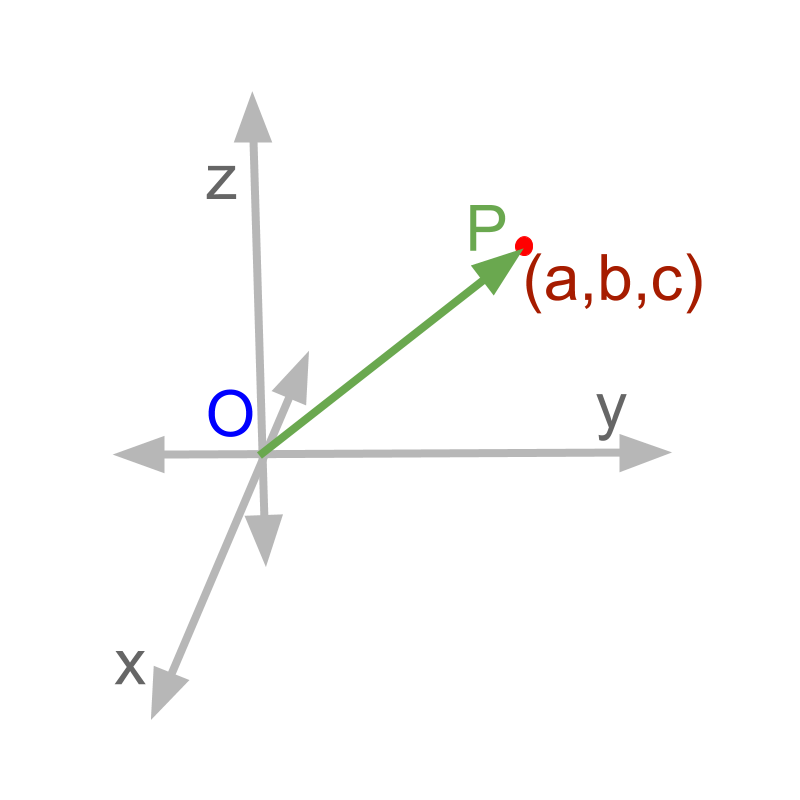

The velocity vector represents the rate of change of the position vector with respect to time. It consists of three components: vx, vy, and vz. Here's the definition:

Velocity Vector: **v = (vx, vy, vz)**

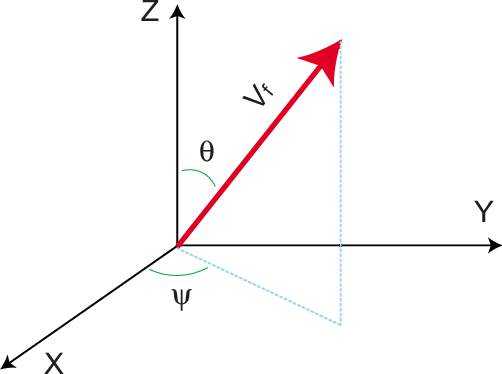

The position and velocity vectors are crucial in determining the quadrotor's position and motion within the simulation. By updating these vectors using appropriate dynamics equations and numerical integration methods, we can accurately simulate the quadrotor's trajectory and behavior.

In [62]:
import numpy as np

# Define the rotation angle in radians
theta = np.pi/4  # Example: 45 degrees

# Create the rotation matrix
R = np.array([[np.cos(theta), -np.sin(theta), 0],
              [np.sin(theta), np.cos(theta),  0],
              [0,             0,              1]])

# Print the rotation matrix
print(R)



[[ 0.70710678 -0.70710678  0.        ]
 [ 0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]]


**By considering 4 motors for inputs,**

In [63]:
# Define control inputs (motor speeds or thrust values)
w1 = 0.8  # Motor speed for rotor 1
w2 = 0.6  # Motor speed for rotor 2
w3 = 0.7  # Motor speed for rotor 3
w4 = 0.9  # Motor speed for rotor 4


w1, w2, w3, w4 are indicators of the motor speeds.

These control inputs determine the forces and moments generated by the rotors, which influence the motion and behavior of the quadrotor in the simulation. You can adjust these values based on your desired control strategy and scenario.

Physical Parameters in Quadrotor Aerial Vehicle (QAV):

- Mass (m):
The mass of the quadrotor represents its total weight and is typically measured in kilograms (kg).

- Gravity (g):
Gravity represents the acceleration due to gravity and affects the quadrotor's vertical motion. It is typically measured in meters per second squared (m/s^2).

- Thrust factor (kF):
The thrust factor relates the motor speed or thrust generated by the rotors to the actual force produced. It is specific to the quadrotor's propellers and is usually determined experimentally.

- Moment arm (L):
The moment arm represents the distance between the quadrotor's center of mass and the rotor axis. It is used to calculate the moments generated by the rotors.

These physical parameters are crucial for defining the dynamics equations and accurately simulating the quadrotor's motion. You can adjust these values according to the specific quadrotor model and simulation requirements.


The Dynamic Equations

Linear acceleration:
The linear acceleration of the quadrotor is influenced by the gravitational force and the thrust generated by the rotors. The equation is given by:





In [64]:
import numpy as np

g = 9.81  # Acceleration due to gravity in m/s^2
m = 1.5  # Mass of the quadrotor in kg
kF = 0.5  # Thrust factor of the quadrotor
L = 0.2  # Moment arm of the quadrotor in meters

# Define control inputs (motor speeds or thrust values)
w1 = 0.8  # Motor speed for rotor 1
w2 = 0.6  # Motor speed for rotor 2
w3 = 0.7  # Motor speed for rotor 3
w4 = 0.9  # Motor speed for rotor 4

a = np.array([0, 0, -g]) + (1/m) * (kF * (w1 + w2 + w3 + w4))
print(a)


[ 1.    1.   -8.81]


In this equation, alpha represents the angular acceleration vector in the roll, pitch, and yaw directions, Ixx, Iyy, and Izz are the moments of inertia about the principal axes, L is the moment arm, kF is the thrust factor, kM is a constant related to the moment produced by the rotors, and w1, w2, w3, and w4 are the motor speeds or thrust values for the four rotors.

These dynamic equations describe the quadrotor's linear and angular accelerations based on the control inputs and physical parameters. By integrating these equations over time using numerical methods, we can simulate the quadrotor's motion in the simulation.

In [65]:
import numpy as np

# Define the moment of inertia values
Ixx = 0.7
Iyy = 0.8
Izz = 0.2

# Define the motor constant
kM = 1.2

# Define control inputs (motor speeds)
w1 = 0.8  # Motor speed for rotor 1
w2 = 0.6  # Motor speed for rotor 2
w3 = 0.7  # Motor speed for rotor 3
w4 = 0.9  # Motor speed for rotor 4

# Calculate the angular accelerations
alpha = np.array([(1/Ixx) * L * (kF * (w2 - w4)),
                  (1/Iyy) * L * (kF * (w1 - w3)),
                  (-1/Izz) * kM * (w1 - w2 + w3 - w4)])

# Print the angular accelerations
print(alpha)


[-0.04285714  0.0125     -0.        ]


$TASK 03$

Derive a PID controller for the attitude control of a quadrorotor and use simulations to demibstrate the very large region of stability of the controller

# Spatial Error Dynamics

Consider a desired trajectory $(o(t), R_r(t))$, and let $\omega_r(t)$ satisfy $\widehat{\omega}_r(t) = \dot{R}_r R_r^T$.

Defining the reference spatial linear momentum as $p_r \triangleq M\dot{o}_r$ and the spatial angular momentum as $\pi_r \triangleq R_r \mathbb{I} R_r^T \omega_r$.

We can define the configuration error as follows:
\begin{align}
o_e &= o_r - o, \\
R_e &= R_r R^T.
\end{align}

The spatial angular velocity of the tracking error, denoted by $\widehat{\omega}_e$, is given by:
\begin{align}
\widehat{\omega}_e &= \dot{R}_e R_e^T = \widehat{\omega}_r(t) - R_e \widehat{\omega}(t) R_e^T.
\end{align}

Hence, we have:
\begin{align}
\omega_e &= \omega_r - R_e \omega.
\end{align}

We can define the angular momentum error as:
\begin{align}
\pi_e \triangleq R \mathbb{I} R_r^T \omega_e = R \mathbb{I} R_r^T (\omega_r - R_e \omega) = R_e^T \pi_r - \pi.
\end{align}

Similarly, the linear momentum error is defined as:
\begin{align}
p_e \triangleq p_r - p.
\end{align}

Differentiating $\pi_e$, we obtain:
\begin{align}
\dot{\pi}_e &= R_e^T (\dot{\pi}_r - \omega_e \times \pi_r) - \dot{\pi} \\
&= R_e^T (R_r \dot{\Pi}_r + (\omega_r - \omega_e) \times \pi_r) - \dot{\pi} \\
&= (R \dot{\Pi}_r + \omega \times \pi_r) - \dot{\pi}.
\end{align}


In [66]:
def externalForceModel(qq, parameters, X):
    # Heavy Top Object
    R = X[0][0]
    M = parameters['M']
    g = parameters['g']
    CM = parameters['CM']
    fe = np.array([0, 0, 0])
    taue = (-M * g * qq.hatMatrix(R @ CM) @ [0, 0, 1])
    return [taue, fe]


def actuator(qq, parameters, t, X, taue, fe):
    Uc = controller(qq, parameters, t, X, taue, fe)
    tauu = Uc[0]
    fu = Uc[1]
    return [tauu, fu]


In [67]:
def referenceConfig(qq,refParameters,t):
  II=refParameters;
  dotOmegart=np.array([0,.01,0]);
  dotPir=II@dotOmegart;
  Omegart=np.array([0,0,0])+dotOmegart*t;
  Pir=II@Omegart;
  thetaOmegart=linalg.norm(Omegart)*t+0*np.pi;
  nOmegart=Omegart/(0.000001+linalg.norm(Omegart));
  qOmegart=np.concatenate(([np.cos(thetaOmegart/2)],np.sin(thetaOmegart/2)*nOmegart));
  Rr=np.array([[1,0,0],[0,1,0],[0,0,1]]);
  return [Rr,Pir,dotPir]

def controller(qq,parameters,t,X,taue,fe):
  #Fully Actuated PD Controller
  II=parameters['II'];
  R=X[0][0]; omega=X[1]; piI=X[3];
  [Rr,Pir,dotPir]=referenceConfig(qq,II,t);
  pir=Rr@Pir;
  omegar=Rr@linalg.inv(II)@Pir;
  Re=Rr@R.T;
  pie=R @ II @ Rr.T @ (omegar-Re@omega);
  K=np.array([[1,0,0],[0,2,0],[0,0,3]]);
  eRhat=0.5*(Re@K-K@Re.T);
  eR=np.array([-eRhat[1,2],eRhat[0,2],-eRhat[0,1]]);
  tauu=(R@dotPir+qq.hatMatrix(omega)@pir)-0.*taue+(4*eR+10*pie+2.*piI) #tauu with PID parts added
  fu=np.array([0,0,0]);
  return [tauu,fu,eR,pie]

def controller_dynamics(qq, t,X,taue,fe,parameters):
  Xc=X[3];
  Uc=controller(qq,parameters,t,X,taue,fe);
  eR=Uc[2];
  dXc=eR;
  return dXc

#Defining the rotational matrix in the 3 axix(x,y,z)
def R_from_h (t1,t2,t3):
  R1=np.array([[1,0,0],[0,np.cos(t1),-np.sin(t1)],[0,np.sin(t1),np.cos(t1)]])
  R2=np.array([[np.cos(t2),0,np.sin(t2)],[0,1,0],[-np.sin(t2),0,np.cos(t2)]])
  R3=np.array([[np.cos(t3),-np.sin(t3),0],[np.sin(t3),np.cos(t3),0],[0,0,1]])
  R_1=R1@R2
  R=R_1@R3
  return R

In [68]:
cubeDimensions={'l':2.,'w':2.,'h':0.5,'xp':1.,'yp':1.,'zp':0.25,};
parameters={'CM':np.array([cubeDimensions['l']/2-cubeDimensions['xp'],cubeDimensions['w']/2-cubeDimensions['yp'],cubeDimensions['h']/2-cubeDimensions['zp']]), 'g':1, 'M':1, 'II':np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])};
ICR=R_from_h(np.pi/3,0,0);
IComega=np.array([0.,0.,0.]); ICo=np.array([0.,0.,0.]); ICp=np.array([0.,0.,0.]);
ICXC=np.array([0,0,0]);
ICs=[[ICR,ICo],IComega,ICp,ICXC]

In [69]:
aa4=mr.simulating_a_cube(0.1, 1000., cubeDimensions, parameters,ICs)
fig1=mr.animated_cube_flat_shading(aa4,'Fully Actuated Cube Pivoted at a Vertex')